In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

np.set_printoptions(precision=4)

In [2]:
data = pd.read_csv('../input/da-project/final_df.csv')

In [3]:
data.head()

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,podium,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1983,1,False,False,True,False,False,keke_rosberg,1,15,...,0,0,0,0,0,0,0,0,0,1
1,1983,1,False,False,True,False,False,prost,2,6,...,0,0,0,1,0,0,0,0,0,0
2,1983,1,False,False,True,False,False,tambay,3,4,...,0,0,0,0,0,0,0,0,0,0
3,1983,1,False,False,True,False,False,piquet,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1983,1,False,False,True,False,False,warwick,5,7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#creating custom scoring function for the regressor 
#used as metric for predict 

def score_regression(model):
    score = 0
    for circuit in df[df.season == 2019]['round'].unique():

        test = df[(df.season == 2019) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict(X_test), columns = ['results'])
        prediction_df['podium'] = y_test.reset_index(drop = True)
        prediction_df['actual'] = prediction_df.podium.map(lambda x: 1 if x == 1 else 0)
        prediction_df.sort_values('results', ascending = True, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)

        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2019]['round'].unique().max()
    return score

In [5]:
#scoring metric for classification

def score_classification(model):
    score = 0
    for circuit in df[df.season == 2019]['round'].unique():

        test = df[(df.season == 2019) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        prediction_df['actual'] = y_test.reset_index(drop = True)
        prediction_df.sort_values('proba_1', ascending = False, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)

        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2019]['round'].unique().max()
    return score

In [6]:
#creating a dictionary to store the results of the model

comparison_dict ={'model':[],
                  'params': [],
                  'score': []}

In [7]:
df=data.copy()

train = df[df.season <2019]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [8]:
#linear regression
params={'fit_intercept': ['True', 'False']}

for fit_intercept in params['fit_intercept']:
    model_params = (fit_intercept)
    model = LinearRegression(fit_intercept = fit_intercept)
    model.fit(X_train, y_train)
            
    model_score = score_regression(model)
            
    comparison_dict['model'].append('linear_regression')
    comparison_dict['params'].append(model_params)
    comparison_dict['score'].append(model_score)

In [9]:
# Random Forest Regressor

params={'criterion': ['squared_error'],
        'max_features': [0.8, 'auto', None],
        'max_depth': list(np.linspace(3, 3, 3)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestRegressor(criterion = criterion,
                                          max_features = max_features, max_depth = max_depth, random_state = 1)
            model.fit(X_train, y_train)
            
            model_score = score_regression(model)
            
            comparison_dict['model'].append('random_forest_regressor')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

In [10]:
# Support Vector Machines

params={'gamma': np.logspace(-4, -1, num=3),
        'C': np.logspace(-2, 1, num=3),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

for gamma in params['gamma']:
    for c in params['C']:
        for kernel in params['kernel']:
            model_params = (gamma, c, kernel)
            model = svm.SVR(gamma = gamma, C = c, kernel = kernel)
            model.fit(X_train, y_train)
            
            model_score = score_regression(model)
            
            comparison_dict['model'].append('svm_regressor')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

#Classification models 

In [11]:
#classififcation
df = data.copy()
df.podium = df.podium.map(lambda x: 1 if x == 1 else 0)            

In [12]:
#split train

train = df[df.season <2019]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)


In [13]:
# gridsearch dictionary

comparison_dict ={'model':[],
                  'params': [],
                  'score': []}

In [14]:
# Logistic Regression

params={'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': np.logspace(-3,1,20)}

for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
            
            comparison_dict['model'].append('logistic_regression')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

In [15]:
# Random Forest Classifier

params={'criterion': ['gini', 'entropy'],
        'max_features': [0.8, 'auto', None],
        'max_depth': list(np.linspace(3, 3, 3)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
            
            comparison_dict['model'].append('random_forest_classifier')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

In [16]:
# Support Vector Machines

params={'gamma': np.logspace(-4, -1, num=3),
        'C': np.logspace(-2, 1, num=3),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

for gamma in params['gamma']:
    for c in params['C']:
        for kernel in params['kernel']:
            model_params = (gamma, c, kernel)
            model = svm.SVC(probability = True, gamma = gamma, C = c, kernel = kernel )
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
            
            comparison_dict['model'].append('svm_classifier')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)


In [17]:
pd.DataFrame(comparison_dict).groupby('model')['score'].max()

model
logistic_regression         12.0
random_forest_classifier    10.0
svm_classifier              11.0
Name: score, dtype: float64

<BarContainer object of 140 artists>

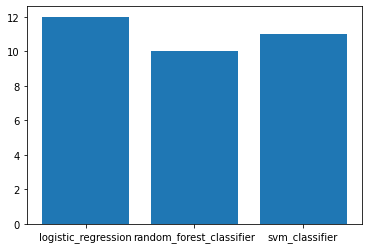

In [18]:
import matplotlib.pyplot as plt

plt.bar(x=comparison_dict['model'],height=comparison_dict['score'])